# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision Mini)

Using 101 classes. 

Goal: Beat original food 101 paper accuracy : 50.76%

In [2]:
!nvidia-smi

Sat Jan 14 06:44:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-14 06:44:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-14 06:44:23 (90.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import helper functions
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

## 101 Food Classes: working with less data



In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2023-01-14 06:44:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   186MB/s    in 9.6s    

2023-01-14 06:44:36 (162 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# How many images/classes
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hummus'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_cl

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode='categorical',
                                                                               image_size=IMG_SIZE,
                                                                               shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with trainsfer learning on 10% of 101 food classes

Steps we are going to take

1. Create a ModelCheckpoint callback
2. Create a data augmentation layer
3. Build a headless(no top layers) Functional EfficientNetB0 backboned-model (Will create our own output layer)
4. Compile 
5. Feature extract for 5 epochs (validate on 15% of testing data for each epoch)


In [8]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [9]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    # preprocessing.Rescaling(1/255.) 
],name='data_augmentation')


In [10]:
# Setup the bease model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with tranable top layers
inputs = layers.Input(shape=(224,224,3),name='input_layer')
x = data_augmentation(inputs)
x = base_model(x,training=False) 
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax',name='output_layer')(x)
model = tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [13]:
from tensorflow.python import test
# Fit the model
history_0 = model.fit(train_data_all_10_percent,
                      epochs = 5,
                      validation_data = test_data,
                      validation_steps = int(0.15*len(test_data)),
                      callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3837 - accuracy: 0.2734

237/237 [==============================] - 133s 500ms/step - loss: 3.3837 - accuracy: 0.2734 - val_loss: 2.5683 - val_accuracy: 0.4325
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.2089 - accuracy: 0.4939

237/237 [==============================] - 106s 444ms/step - loss: 2.2089 - accuracy: 0.4939 - val_loss: 2.0782 - val_accuracy: 0.5082
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8281 - accuracy: 0.5687

237/237 [==============================] - 102s 428ms/step - loss: 1.8281 - accuracy: 0.5687 - val_loss: 1.8984 - val_accuracy: 0.5307
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.6027 - accuracy: 0.6160

237/237 [==============================] - 98s 411ms/step - loss: 1.6027 - accuracy: 0.6160 - val_loss: 1.8403 - val_accuracy: 0.5358
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.4439 - accuracy: 0.6523

237/237 [==============================] - 95s 397ms/step - loss: 1.4439 - accuracy: 0.6523 - val_loss: 1.8044 - val_accuracy: 0.5384


In [14]:
# Evaluate the model
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 67s 84ms/step - loss: 1.5828 - accuracy: 0.5867


[1.5828183889389038, 0.5866930484771729]

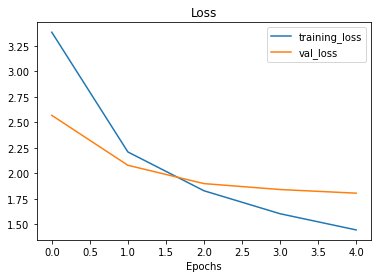

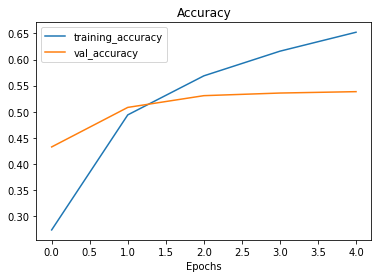

In [15]:
plot_loss_curves(history_0)

## Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layers.trainable = False

In [17]:
# Recompile model with lowe learning 
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.0001), # reduce by 10x
    metrics = ['accuracy']
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# Check which layers are trainable in our base model
for layer_number,layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 tf.math.truediv True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     initial_epoch=history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 198s 784ms/step - loss: 1.1729 - accuracy: 0.6836 - val_loss: 1.7254 - val_accuracy: 0.5583
Epoch 6/10
237/237 [==============================] - 166s 702ms/step - loss: 0.8811 - accuracy: 0.7570 - val_loss: 1.6725 - val_accuracy: 0.5834
Epoch 7/10
237/237 [==============================] - 152s 640ms/step - loss: 0.6772 - accuracy: 0.8141 - val_loss: 1.8833 - val_accuracy: 0.5543
Epoch 8/10
237/237 [==============================] - 145s 610ms/step - loss: 0.5098 - accuracy: 0.8524 - val_loss: 1.8766 - val_accuracy: 0.5694
Epoch 9/10
237/237 [==============================] - 141s 591ms/step - loss: 0.3664 - accuracy: 0.8944 - val_loss: 1.7905 - val_accuracy: 0.5930
Epoch 10/10
237/237 [==============================] - 137s 576ms/step - loss: 0.2822 - accuracy: 0.9151 - val_loss: 2.3820 - val_accuracy: 0.5220


In [22]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 77s 98ms/step - loss: 1.8917 - accuracy: 0.5964


[1.8917068243026733, 0.5963960289955139]

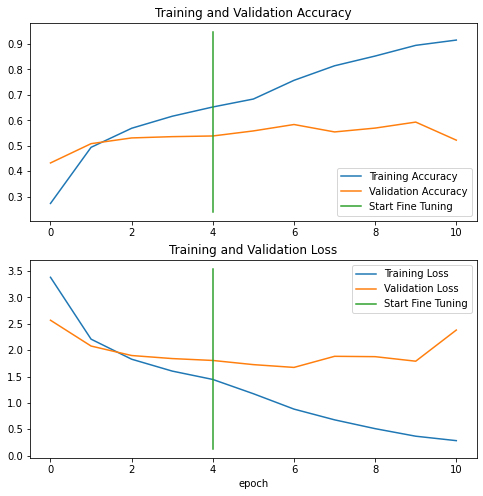

In [23]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_0,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we will need to save it and export it somewhere

In [24]:
# Save our fine-tuned model
model.save('drive/MyDrive/Tensorflow_Certificate/101_food_classes_10_percent_saved_big_dog_model')

In [29]:
# Load saved model
loaded_model = tf.keras.models.load_model('drive/MyDrive/Tensorflow_Certificate/101_food_classes_10_percent_saved_big_dog_model')

KeyboardInterrupt: ignored

In [27]:
# Evaluate loaded model and compare to previous model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 71s 88ms/step - loss: 1.8917 - accuracy: 0.5964


[1.891707181930542, 0.5963960289955139]

In [28]:
# The result above should be similar to results below
all_classes_10_percent_fine_tune_results

[1.8917068243026733, 0.5963960289955139]

## Evlauating the performance of the big dog model across all different classes

Let's make some predictioins, visualize them and then later find out which predictions were the 'most' wrong.

In [30]:
import tensorflow as tensorflow
# Donwload pretrained model pretrained earlier
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-01-14 07:18:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.107.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   113MB/s    in 0.4s    

2023-01-14 07:18:00 (113 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [31]:
# Unzip the data
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [32]:
# Loading the model
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [33]:
# Evaluate the model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 70s 87ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [34]:
# Make predictions
preds_probs = model.predict(test_data,verbose=1) # set verbosity to see how long is left

790/790 [==============================] - 64s 79ms/step


In [35]:
# How many predictions are there?
len(preds_probs)

25250

In [36]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [37]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542041e-02, 3.5742053e-06, 4.1376803e-02, ..., 1.4138708e-09,
        8.3530598e-05, 3.0897530e-03],
       [9.6401680e-01, 1.3753194e-09, 8.4780209e-04, ..., 5.4286946e-05,
        7.8361918e-12, 9.8465647e-10],
       [9.5925879e-01, 3.2533717e-05, 1.4866921e-03, ..., 7.1891350e-07,
        5.4397532e-07, 4.0276082e-05],
       ...,
       [4.7313261e-01, 1.2931234e-07, 1.4805571e-03, ..., 5.9750129e-04,
        6.6969093e-05, 2.3469318e-05],
       [4.4571854e-02, 4.7265522e-07, 1.2258522e-01, ..., 6.3498674e-06,
        7.5318649e-06, 3.6778811e-03],
       [7.2438961e-01, 1.9249846e-09, 5.2310996e-05, ..., 1.2291390e-03,
        1.5792685e-09, 9.6395743e-05]], dtype=float32)

In [38]:
# What does the first prediction probabitlity array look like
preds_probs[0] , len(preds_probs[0]), sum(preds_probs[0])

(array([5.9542041e-02, 3.5742053e-06, 4.1376803e-02, 1.0660536e-09,
        8.1613978e-09, 8.6639664e-09, 8.0927055e-07, 8.5652584e-07,
        1.9859037e-05, 8.0977844e-07, 3.1727685e-09, 9.8673934e-07,
        2.8532150e-04, 7.8048906e-10, 7.4230199e-04, 3.8916383e-05,
        6.4740493e-06, 2.4977257e-06, 3.7891168e-05, 2.0678289e-07,
        1.5538468e-05, 8.1507341e-07, 2.6230621e-06, 2.0010727e-07,
        8.3827535e-07, 5.4215934e-06, 3.7391037e-06, 1.3150533e-08,
        2.7761499e-03, 2.8051867e-05, 6.8562162e-10, 2.5574906e-05,
        1.6688929e-04, 7.6407003e-10, 4.0452901e-04, 1.3150634e-08,
        1.7957395e-06, 1.4448203e-06, 2.3062935e-02, 8.2466863e-07,
        8.5365861e-07, 1.7138630e-06, 7.0525307e-06, 1.8402273e-08,
        2.8553430e-07, 7.9483771e-06, 2.0681496e-06, 1.8525223e-07,
        3.3619774e-08, 3.1522568e-04, 1.0410943e-05, 8.5448448e-07,
        8.4741873e-01, 1.0555466e-05, 4.4094878e-07, 3.7404185e-05,
        3.5306264e-05, 3.2489010e-05, 6.7314875e

In [39]:
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'What prediction probability sample 0 looks like:\n {preds_probs[0]}')
print(f'The clas with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9542041e-02 3.5742053e-06 4.1376803e-02 1.0660536e-09 8.1613978e-09
 8.6639664e-09 8.0927055e-07 8.5652584e-07 1.9859037e-05 8.0977844e-07
 3.1727685e-09 9.8673934e-07 2.8532150e-04 7.8048906e-10 7.4230199e-04
 3.8916383e-05 6.4740493e-06 2.4977257e-06 3.7891168e-05 2.0678289e-07
 1.5538468e-05 8.1507341e-07 2.6230621e-06 2.0010727e-07 8.3827535e-07
 5.4215934e-06 3.7391037e-06 1.3150533e-08 2.7761499e-03 2.8051867e-05
 6.8562162e-10 2.5574906e-05 1.6688929e-04 7.6407003e-10 4.0452901e-04
 1.3150634e-08 1.7957395e-06 1.4448203e-06 2.3062935e-02 8.2466863e-07
 8.5365861e-07 1.7138630e-06 7.0525307e-06 1.8402273e-08 2.8553430e-07
 7.9483771e-06 2.0681496e-06 1.8525223e-07 3.3619774e-08 3.1522568e-04
 1.0410943e-05 8.5448448e-07 8.4741873e-01 1.0555466e-05 4.4094878e-07
 3.7404185e-05 3.5306264e-05 3.2489010e-05 6.7314875e-05 1.2852592e-08
 2.6219760e-10 1.0318110e-05 8.5744046e-05 1.

In [40]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

#How do thet look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [41]:
# How many pred classes do we have?
len(pred_classes)

25250

In [43]:
# to get our test labels, we need to unravel our test_data BatchDataset
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0,1....,0,0]. we want the index value where the '1' occurs
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [45]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score

In [46]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [47]:
# Let;s try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [48]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## Making a Confusion Matrix

In [49]:
from helper_functions import make_confusion_matrix

In [50]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                       figsize=(100,100),
                       text_size=20)